In [202]:
# !pip install PYEVALB
# !pip install unidecode

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import Tree, grammar
import random
import queue
import pickle as pkl
from scipy.spatial import distance
from PYEVALB import scorer
from PYEVALB import parser
from sklearn.metrics import precision_recall_fscore_support
import unidecode

In [2]:
with open('sequoia-corpus+fct.mrg_strict', 'r') as file:
    data = file.read().splitlines()
    
file.close()

In [3]:
def ignore_functional_labels(string):
    
    """
    Description
    ----------------
    Ignore functional labels in the non terminals of a rule, for example PP-MOD becomes PP
    
    Parameters
    ----------------
    string : String form of parse tree.
    
    Returns
    ----------------
    new string form of parse tree
    """
    
    l = string.split(' ')
    for i in range(len(l)):
        if l[i][0] == '(':
            l[i] = l[i].split('-')[0]
            
    return ' '.join(l)
    

In [4]:
def extract_nodes(rule):
    
    """
    Description
    ---------------
    Extract the non terminal and terminal nodes from a rule along with the status of the rule (either lexical 1, or not 0)
    
    Parameters
    ---------------
    rule : nltk.grammar.Production object, the rule to consider.
    
    Returns
    ---------------
    3-tuple, tuple[0] : the lexical status.
             tuple[1] : set containing the non terminal nodes.
             tuple[2] : set containing the terminal nodes.
    """
    if rule.is_lexical():
        return True, set((rule._lhs,)), set((rule._rhs))
    
    else:
        return False, set((rule._lhs,)).union(set(rule._rhs)), set()

In [5]:
non_terminals = set()
pos_tags = set()
terminals = set()
binaries = set()
for string in data:
    t = Tree.fromstring(ignore_functional_labels(string))
    t.chomsky_normal_form()
    rules = t.productions()
    for rule in rules:
        lexical, non_terminal_nodes, terminal_nodes = extract_nodes(rule)
        if lexical:
            non_terminals = non_terminals.union(non_terminal_nodes)
            pos_tags = pos_tags.union(non_terminal_nodes)
            terminals = terminals.union(terminal_nodes)
            
        else:
            non_terminals = non_terminals.union(non_terminal_nodes)
            if len(rule._rhs) == 2:
                binaries.add(rule._rhs)

# non_terminals = non_terminals.difference(pos_tags)
start = rules[0]._lhs   # The start symbol
sent = rules[0]._rhs[0] # The previous start symbol

In [6]:
print('Number of terminals : %d' %len(terminals))
print('Number of POS tags : %d' %len(pos_tags))
print('Number of non terminals : %d' %len(non_terminals))
print('Number of binaries : %d' %len(binaries))

Number of terminals : 10378
Number of POS tags : 29
Number of non terminals : 5129
Number of binaries : 7269


In [7]:
dict_symbol_non_terminal = dict((non_terminal._symbol, non_terminal) for non_terminal in non_terminals)

In [8]:
dict_non_terminals_indices = {non_terminal : index for index, non_terminal in enumerate(non_terminals)}
dict_indices_non_terminals = {index : non_terminal for non_terminal, index in dict_non_terminals_indices.items()}

dict_pos_indices = {pos : index for index, pos in enumerate(pos_tags)}
dict_indices_pos = {index : pos for pos, index in dict_pos_indices.items()}

dict_terminals_indices = {terminal : index for index, terminal in enumerate(terminals)}
dict_indices_terminals = {index : terminal for terminal, index in dict_terminals_indices.items()}

dict_binaries_indices = {binary : index for index, binary in enumerate(binaries)}
dict_indices_terminals = {index : binary for binary, index in dict_binaries_indices.items()}

In [9]:
# random.seed(0)
# random.shuffle(data)
# data_train, data_dev, data_test = data[:4*len(data)//5], data[4*len(data)//5:9*len(data)//10], data[9*len(data)//10:]
# del data

# PCFG

In [10]:
def express_node(rule):
    
    """
    Description
    ---------------
    Express the nature of the rule and extract its left hand and right hand sides.
    
    Parameters
    ---------------
    rule : nltk.grammar.Production object, the rule to consider.
    
    Returns
    ---------------
    3-tuple, tuple[0] : String describing the rule {'lexical', 'start_node', 'unary', 'binary'}
             tuple[1] : nltk.grammar.Production, the left hand side of the rule.
             tuple[2] : nltk.grammar.Production, the right hand side of the rule.
    """
    if rule.is_lexical():
        return 'lexical', rule._lhs, rule._rhs[0]
    
    else:
        lhs, rhs = rule._lhs, rule._rhs
        if rhs[0] == sent:
            return 'start_node', lhs, rhs[0]
        
        elif len(rhs) == 1:
            return 'unary', lhs, rhs[0]
        
#         elif len(rhs) == 1 and rhs[0] == sent:
#             return 'start_node -> sent', lhs, rhs[0]
        
        elif len(rhs) == 2:
            return 'binary', lhs, rhs

In [11]:
def pcfg(data):
    
    """
    Description
    ----------------
    Create PCFG model from the data, i.e compute the probability of each rule (conditiona probabilities) statistically from the data
    
    Parameters
    ----------------
    data : List of strings representing parse trees.
    
    Returns
    ----------------
    dict_pcfg   : Dictionnary with three keys {'lexical', 'unary', 'binary'}
                 - dict_pcfg['lexical']  : dictionnary of lexicons.
                                           - keys   : POS tags; 
                                           - values : dictionnary of probabilities p(terminal|POS_tag)
                                                     - keys   : terminals.
                                                     - values : p(terminal|POS_tag)
                 - dict_pcfg['unary']    : dictionnary of unary laws.
                                           - keys   : non terminals; 
                                           - values : dictionnary of probabilities p(node|non_terminal), node here can be
                                                      either a POS tag or a non terminal.
                                                     - keys   : non terminals.
                                                     - values : p(node|non_terminal)
                                                                          
                 - dict_pcfg['binary']   : dictionnary of binary laws.
                                           - keys   : non terminals; 
                                           - values : dictionnary of probabilities p(node|non_terminal), node here is binary
                                                      containing POS tags or non terminals.
                                                     - keys   : non terminals.
                                                     - values : p(node|non_terminal)
                                                                        
    dict_probas : Dictionnary rearranging the elements of dict_pcfg in a way that simplifies the use of the probabilities 
                  in the CYK algorithm, keys in {'lexical', 'unary', 'binary'}                  
                  dictionnary of probabilities.
                            - keys   : unary nodes (POS tags or non terminals).
                            - values : probabilities p(node|unary_node)
    """
    
    # Initalize dictionnaries dict_lexicons, dict_unaries, dict_binaries that we put in dict_pcfg
    dict_lexicons, dict_unaries, dict_binaries = {}, {start : {sent : 1.}}, {} # Notice that we already put the rule of the start node in
                                                                              # Chomsky normal form
    dict_pcfg = {'lexical' : dict_lexicons, 'unary' : dict_unaries, 'binary' : dict_binaries}
    
    # Loop over the data
    for string in data:
        t = Tree.fromstring(ignore_functional_labels(string)) # Ignore the functional labels (see the doc of ignore_functional_labels)
        t.chomsky_normal_form()  # Convert the tree to Chomsky normal form
        rules = t.productions()  # Get the rules
        for rule in rules:       # We start by counting the rules in data
            nature, lhs, rhs = express_node(rule)
            if nature in ['lexical', 'unary', 'binary']:
                if lhs in dict_pcfg[nature]:
                    if rhs in dict_pcfg[nature][lhs]:
                        dict_pcfg[nature][lhs][rhs] += 1

                    else:
                        dict_pcfg[nature][lhs][rhs] = 1

                else:
                    dict_pcfg[nature][lhs] = {rhs : 1}

            elif nature == 'start_node':
                continue
                
    dict_normalized = {}
    for nature in dict_pcfg:
        for lhs in dict_pcfg[nature]:
            if lhs in dict_normalized:
                dict_normalized[lhs] += sum(dict_pcfg[nature][lhs].values())
                
            else:
                dict_normalized[lhs] = sum(dict_pcfg[nature][lhs].values())
                
    for nature in dict_pcfg:
        for lhs in dict_pcfg[nature]:
            dict_pcfg[nature][lhs] = dict((key, value/dict_normalized[lhs]) for key, value in dict_pcfg[nature][lhs].items())

    dict_probas = {'lexical' : {}, 'unary' : {}, 'binary' : {}} # Initialize dict_probas
    for nature in dict_pcfg:
        for lhs in dict_pcfg[nature]:
            for node in dict_pcfg[nature][lhs]:
                if node in dict_probas[nature]:
                    dict_probas[nature][node][lhs] = dict_pcfg[nature][lhs][node]

                else:
                    dict_probas[nature][node] = {lhs : dict_pcfg[nature][lhs][node]}
                    
    return dict_pcfg, dict_probas

In [12]:
dict_pcfg, dict_probas = pcfg(data)

# CYK algorithm

In [13]:
def cyk(sentence):
    
    n = len(sentence) + 1
    k = len(non_terminals)
    scores = np.zeros((n, n, k))
    back = [[[None for i in range(k)] for j in range(n)] for l in range(n)]
    for i in range(0, n-1):
        word = sentence[i]
        for A in dict_probas['lexical'][word]:
            scores[i, i+1, dict_non_terminals_indices[A]] = dict_probas['lexical'][word][A]
                        
        added = True
        while added:
            added = False
            for B in dict_probas['unary']:
                score_B = scores[i, i+1, dict_non_terminals_indices[B]]
                if score_B > 0:
                    for A in dict_probas['unary'][B]:
                        prob = dict_probas['unary'][B][A]*score_B
                        if prob > scores[i, i+1, dict_non_terminals_indices[A]]:
                            scores[i, i+1, dict_non_terminals_indices[A]] = prob
                            back[i][i+1][dict_non_terminals_indices[A]] = B
                            added = True
                                                        
    for span in range(2, n):
        for begin in range(0, n-span):
            end = begin + span
            for split in range(begin+1, end):
                for B, C in dict_probas['binary']:
                    score_B, score_C = scores[begin, split, dict_non_terminals_indices[B]], scores[split, end, dict_non_terminals_indices[C]]
                    if score_B*score_C > 0:
                        for A in dict_probas['binary'][(B, C)]:
                            prob = score_B*score_C*dict_probas['binary'][(B, C)][A]
                            if prob > scores[begin, end, dict_non_terminals_indices[A]]:
                                scores[begin, end, dict_non_terminals_indices[A]] = prob
                                back[begin][end][dict_non_terminals_indices[A]] = (split, B, C)
                                
            added = True
            while added:
                added = False
                for B in dict_probas['unary']:
                    score_B = scores[begin, end, dict_non_terminals_indices[B]]
                    if score_B > 0:
                        for A in dict_probas['unary'][B]:
                            prob = prob = dict_probas['unary'][B][A]*score_B
                            if prob > scores[begin, end, dict_non_terminals_indices[A]]:
                                scores[begin, end, dict_non_terminals_indices[A]] = prob
                                back[begin][end][dict_non_terminals_indices[A]] = B
                                added = True
                                
                                
    return scores, back

In [14]:
len(dict_probas['unary']) + len(dict_probas['binary'])

7297

# Backtrack : Build parse tree from CYK

In [15]:
def build_parentheses(back_track):
    
    """
    Description
    ---------------
    Build the parse tree from tha back_track return of CYK algorithm as a string with parentheses. Then if we want to get the parse
    in a tree form, we can simply use function Tree.from_string of nltk package.
    
    Parameters
    ---------------
    back_track : 3D matrix in the form of list of lists, of "shape" (n, n, r).
                 - n : the length of the sentence we want to parse.
                 - r : the number of non terminal nodes in our grammar.
                 
    Returns
    ---------------
    String, the string form with parentheses of the parse tree.
    """
    
    string = '('
    q = queue.LifoQueue()
    begin = 0
    end = len(back_track[0]) - 1
    q.put((None, sent, 'start', 1, [begin, end]))

    while not q.empty():
        split, symbol, status, depth, border = q.get()   # border is begin for left and end for right
        string += ' (' + symbol._symbol

        if status == 'left':
            border = [border[0], split]
            children = back[border[0]][border[1]][dict_non_terminals_indices[symbol]]

        elif status == 'right':
            border = [split, border[1]]
            children = back[border[0]][border[1]][dict_non_terminals_indices[symbol]]

        elif status == 'start':
            children = back[border[0]][border[1]][dict_non_terminals_indices[symbol]]

        if children is not None:
            if isinstance(children, grammar.Nonterminal):
                node = (split, children, status, depth+1, border)
                q.put(node)

            elif len(children) == 3:
                split, l_child, r_child = children
                l_node, r_node = (split, l_child, 'left', 0, border), (split, r_child, 'right', depth+1, border)
                q.put(r_node)
                q.put(l_node)

        else:
            depth += 1
            word = sentence[border[0]:border[1]][0]
            string += ' ' + word + ')'*depth
            
    return string

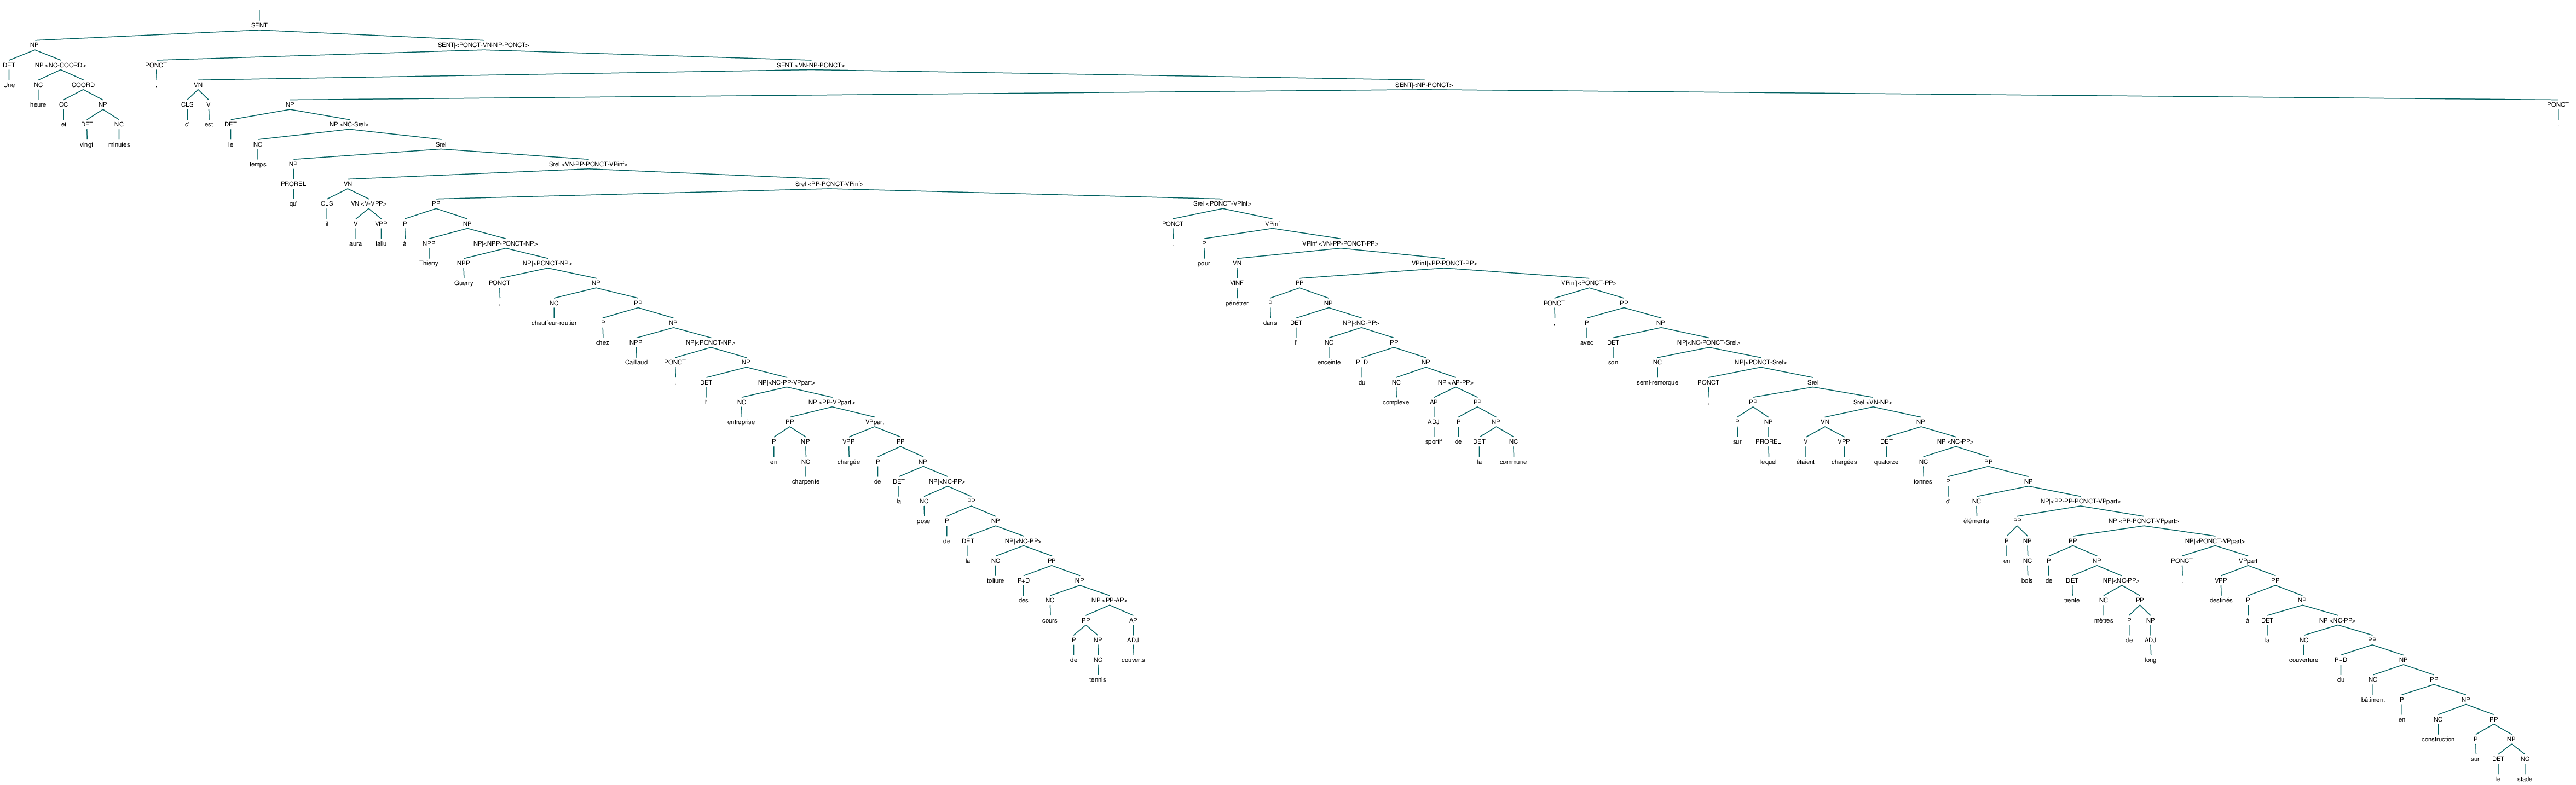

In [110]:
t = Tree.fromstring(ignore_functional_labels(data[97]))
t.chomsky_normal_form()
t

In [81]:
sentence = t.leaves()
len(sentence)

83

In [82]:
from time import time
start_time = time()
scores, back = cyk(sentence)
print(time() - start_time)

2643.805163383484


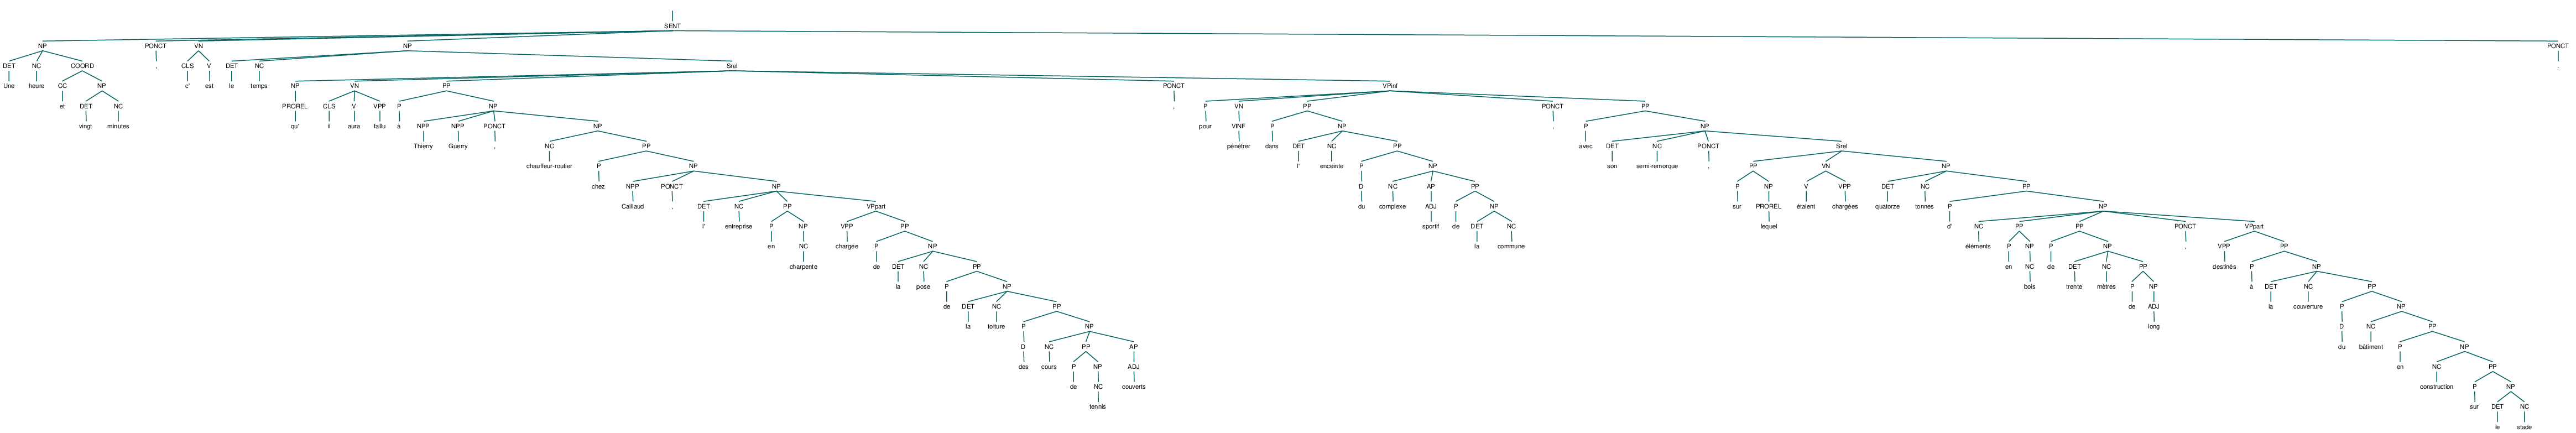

In [90]:
t.un_chomsky_normal_form()
t

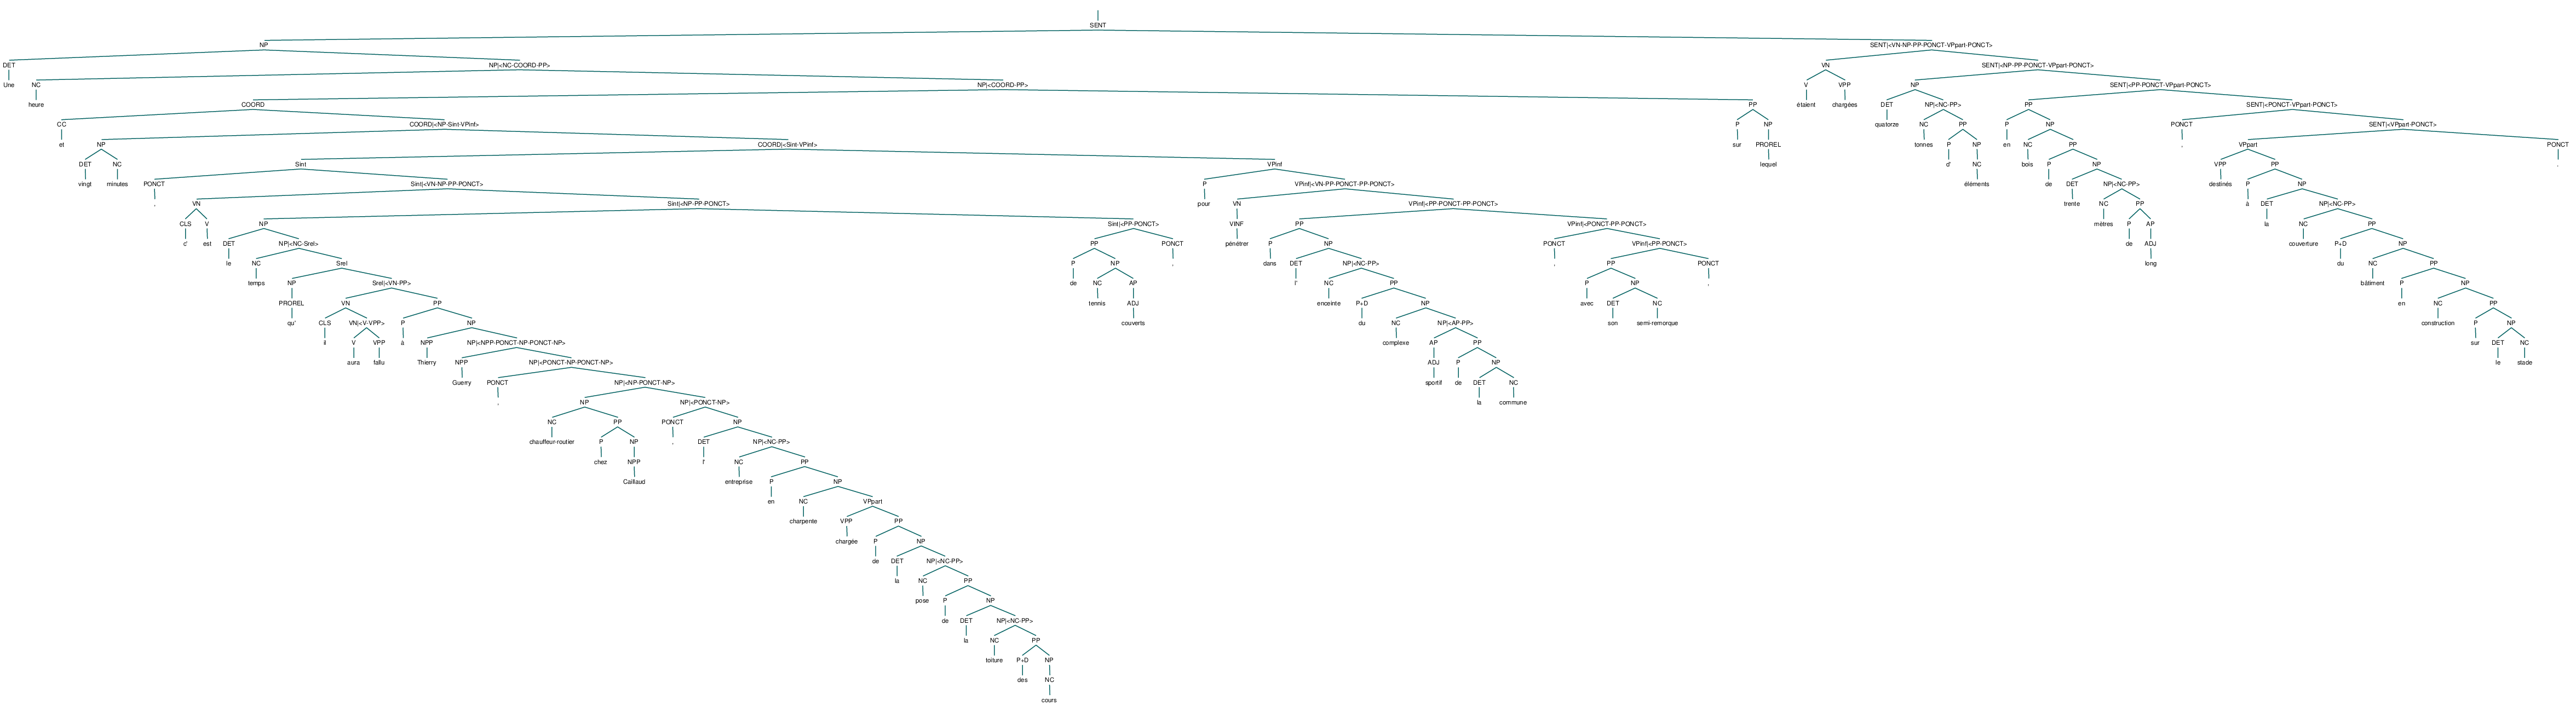

In [111]:
t_test = Tree.fromstring(build_parentheses(back))
# t_test.chomsky_normal_form()
t_test

In [75]:
" ".join(str(t).split()) == " ".join(str(t_test).split())

True

## Evaluation

In [16]:
def score(true_parse, proposed_parse):
    
    """
    Description
    -----------------
    Evaluate a proposed parse given the true one, this function prints recall and precision of the whole parse and on POS tags only also.
    
    Parameters
    -----------------
    true_parse, proposed_parse : Bracketed strings, the true and proposed parse trees.
    
    Returns
    -----------------
    """
    
    true_parse = true_parse[2:-1]
    proposed_parse= proposed_parse[2:-1]
    
    gold_tree = parser.create_from_bracket_string(true_parse)
    test_tree = parser.create_from_bracket_string(proposed_parse)
    
    # Compute recall and precision for POS tags
    y_true = np.array(gold_tree.poss)
    y_pred = np.array(test_tree.poss)

    y_pred = (y_true == y_pred).astype(int)
    y_true = np.ones(len(y_true)).astype(int)

    (POS_precision, POS_recall, POS_f_score, beta) = precision_recall_fscore_support(y_true,y_pred, labels=[1])
    
    # Compute recall and precision for the whole parse
    thescorer = scorer.Scorer() 
    result = thescorer.score_trees(gold_tree, test_tree)
    
    print('Parse recall : {:.2f}%'.format(result.recall*100))
    print('Parse precision : {:.2f}%'.format(result.prec*100), end="\n\n")
    
    print('POS recall : {:.2f}%'.format(POS_recall[0]*100))
    print('POS precision : {:.2f}%'.format(POS_precision[0]*100))

    return None

In [121]:
score(" ".join(str(t).split()), " ".join(str(t_test).split()))

Parse recall : 50.79%
Parse precision : 50.79%

POS recall : 100.00%
POS precision : 100.00%


# OOV module

## Embedding similarity

In [17]:
words, embeddings = pkl.load(open('polyglot-fr.pkl', 'rb'), encoding = 'latin')
dict_words_embeddings = dict((word, embedding) for word, embedding in zip(words, embeddings))
del words, embeddings

In [18]:
word_original = 'homme'
scores = []
for word in dict_words_embeddings:
    scores.append((distance.cosine(dict_words_embeddings[word_original], dict_words_embeddings[word]), word))
    
sorted(scores)[:10]

[(0.0, 'homme'),
 (0.21154648065567017, 'enfant'),
 (0.21763044595718384, 'acteur'),
 (0.28635895252227783, 'avocat'),
 (0.3048095703125, 'officier'),
 (0.3096308708190918, 'auteur'),
 (0.30973005294799805, 'écrivain'),
 (0.3104395270347595, 'entraîneur'),
 (0.31114840507507324, 'art'),
 (0.31358325481414795, 'prêtre')]

## Formal similarity

In [25]:
def levenshtein(s1, s2):
    
    """
    Description
    ---------------
    Computes the Levenshtein distance between two strings.
    
    Parameters
    ---------------
    s1, s2 : The two strings we want to compare.
    
    Returns
    ---------------
    Float, the Levenshtein distance between s1 and s2
    """
    
    s1, s2 = unidecode.unidecode(s1.lower()), unidecode.unidecode(s2.lower())
    n1, n2 = len(s1), len(s2)
    lev = np.zeros((n1 + 1, n2 + 1))
    for i in range(n1 + 1):
        lev[i, 0] = i
        
    for j in range(n2 + 1):
        lev[0, j] = j
        
    for i in range(1, n1 + 1):
        for j in range(1, n2 + 1):
            if s1[i-1] == s2[j-1]:
                lev[i, j] = min(lev[i-1, j] + 1, lev[i, j-1] + 1, lev[i-1, j-1])
                
            else:
                lev[i, j] = min(lev[i-1, j] + 1, lev[i, j-1] + 1, lev[i-1, j-1] + 1)
                
    return lev[n1, n2]

def damerau_levenshtein(s1, s2):
    
    """
    Description
    ---------------
    Computes the Damerau-Levenshtein distance between two strings.
    
    Parameters
    ---------------
    s1, s2 : The two strings we want to compare.
    
    Returns
    ---------------
    Float, the Damerau-Levenshtein distance between s1 and s2
    """
    
    s1, s2 = unidecode.unidecode(s1.lower()), unidecode.unidecode(s2.lower())
    n1, n2 = len(s1), len(s2)
    alphabet = ['!', '"', '#', '$', '%', '&', '(', ')', "'", '*', '+', 
                ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', 
                '[', ']', '^', '_', '`', '{', '|', '}', '~', ' '] + [str(i) for i in range(10)] + ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    dict_alphabet_indices = {char:index for (index, char) in zip(range(len(alphabet)), alphabet)}
    da, d = np.zeros(len(alphabet)).astype(np.int8), np.zeros((n1 + 2, n2 + 2)).astype(np.int8)
    maxdist = n1 + n2
    d[0, 0] = maxdist
    for i in range(n1 + 1):
        d[i+1, 0] = maxdist
        d[i+1, 1] = i
        
    for j in range(n2 + 1):
        d[0, j+1] = maxdist
        d[1, j+1] = j
        
    for i in range(1, n1 + 1):
        db = 0
        for j in range(1, n2 + 1):
            k = da[dict_alphabet_indices[s2[j-1]]]
            l = db
            if s1[i-1] == s2[j-1]:
                cost = 0
                db = j
                
            else:
                cost = 1
                
            d[i+1, j+1] = min(d[i, j] + cost, d[i+1, j] + 1, 
                              d[i, j+1] + 1, d[k, l] + (i-k-1)+1+(j-l-1))
            da[dict_alphabet_indices[s1[i-1]]] = i
            
    return d[-1, -1]
    

## Language model

In [20]:
def unigram(data):
    
    """
    Description
    ---------------
    Compute a unigram model from the corpus data.
    
    Parameters
    ---------------
    data : List of bracketed strings
    
    Returns
    ---------------
    np.array of shape (#words_in_data,) containing the probabilities p(word).
    """
  
    probas = np.zeros(len(terminals))
    for bracketed in data:
        t = Tree.fromstring(bracketed)
        for word in t.leaves():
            probas[dict_terminals_indices[word]] += 1

    return probas/probas.sum()

def bigram(data):
    
    """
    Description
    ---------------
    Compute a bigram model from the corpus data.
    
    Parameters
    ---------------
    data : List of bracketed strings
    
    Returns
    ---------------
    np.array of shape (#words_in_data, #words_in_data) containing the probabilities p(word_current|word_previous).
    """
  
    probas = np.ones((len(terminals), len(terminals)))
    for bracketed in data:
        t = Tree.fromstring(bracketed)
        sentence = t.leaves()
        if len(sentence) >= 2:
            for i in range(1, len(sentence)):
                index_1 = dict_terminals_indices[sentence[i - 1]] # The previous word in the sequene.
                index_2 = dict_terminals_indices[sentence[i]] # The current word in the sequene.
                probas[index_1, index_2] += 1

        else:
            continue

    return probas/((probas.sum(axis = 1).reshape(-1, 1)))

In [21]:
probas_unigram, probas_bigram = unigram(data), bigram(data)

## Assigning OOV words to the training lexique

In [32]:
def closest_formal(s, terminals, thresh = 2, swap = True):
    
    """
    Description
    ---------------
    Get the terminals within a lower Damerau-Levenshtein (or Levenshtein) distance of thresh to the word s.
    
    Parameters
    ---------------
    s         : String, the oov word
    terminals : Set of words we have in our corpus.
    thresh    : Int, the threshold of Damerau-Levenshtein distance.
    swap      : Boolean, True  : Use Damerau-Levenshtein distance.
                         False : Use Levenshtein distance
    
    Returns
    ---------------
    Dictionnary of the closest words.
        keys   : words in terminals.
        values : distance(s, word)
    """
    
    if swap:
        fun = lambda word : damerau_levenshtein(s, word)
        
    else:
        fun = lambda word : levenshtein(s, word)
        
    return {word : score for word, score in zip(terminals, list(map(fun, terminals))) if score <= thresh}

In [33]:
closest_formal('mer', terminals)

{'Me': 1,
 'Metz': 2,
 'm': 2,
 'met': 1,
 'et': 2,
 '2e': 2,
 'ces': 2,
 'je': 2,
 'amer': 1,
 'mêlés': 2,
 'mg': 2,
 'mené': 2,
 'over': 2,
 'peur': 2,
 'Mer': 0,
 'mmol': 2,
 'Ce': 2,
 'UE': 2,
 'Ferry': 2,
 'mis': 2,
 'mêmes': 2,
 'Tir': 2,
 'mot': 2,
 'My': 2,
 'Sur': 2,
 'mène': 2,
 'mai': 2,
 'dès': 2,
 'Vert': 2,
 'De': 2,
 'jeter': 2,
 'verre': 2,
 'père': 2,
 'Mai': 2,
 'ET': 2,
 'de': 2,
 'Cet': 2,
 'DES': 2,
 'PGR': 2,
 'sûr': 2,
 'leur': 2,
 'lever': 2,
 'mort': 2,
 'HCR': 2,
 'mener': 1,
 'War': 2,
 'moi': 2,
 'SAR': 2,
 'LES': 2,
 'gel': 2,
 'gère': 2,
 'En': 2,
 'SUR': 2,
 'EU': 2,
 'Lee': 2,
 'Le': 2,
 'Mères': 2,
 'der': 1,
 'céder': 2,
 'Car': 2,
 'car': 2,
 'CE2': 2,
 'créer': 2,
 'Mal': 2,
 'Merci': 2,
 'fer': 1,
 'EMEA': 2,
 'né': 2,
 'fr': 2,
 'Ferré': 2,
 'ère': 2,
 'Dès': 2,
 'MM.': 2,
 'Eh': 2,
 'for': 2,
 'peser': 2,
 'les': 2,
 '1er': 1,
 'ses': 2,
 '-en': 2,
 'EN': 2,
 'menée': 2,
 'Mayer': 2,
 'war': 2,
 'mères': 2,
 'des': 2,
 'en': 2,
 'Leyr': 2,
 'LE': 

In [84]:
def closest_embedding(s, terminals, n_words = 10):
    
    """
    Description
    ---------------
    Get the terminals within a lower Damerau-Levenshtein (or Levenshtein) distance of thresh to the word s.
    
    Parameters
    ---------------
    s         : String, oov word
    terminals : Set of words we have in our corpus.
    n_words   : Int, number of closest words to s.
    
    Returns
    ---------------
    Dictionnary of the closest words.
        keys   : words in terminals.
        values : cosine_distance(s, word)
    """
    
    fun = lambda word : distance.cosine(dict_words_embeddings[s], dict_words_embeddings[word]) if word in dict_words_embeddings else 1.
    return {score_word[1] : score_word[0] for score_word in sorted(zip(list(map(fun, terminals)), terminals))[:n_words]}

In [85]:
s = 'mer'
closest_embedding(s, terminals)

{'mer': 0.0,
 'terre': 0.22055935859680176,
 'Mer': 0.28404998779296875,
 'ville': 0.3071545362472534,
 'pluie': 0.30734384059906006,
 'forêt': 0.32614070177078247,
 'nature': 0.3320302367210388,
 'lumière': 0.3353707194328308,
 'glace': 0.3402719497680664,
 'Chine': 0.34071099758148193}